<a href="https://colab.research.google.com/github/EkaSulistyawan/strawberry-segmentation/blob/main/IIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import torchvision
import math
import sys
import time
import matplotlib.pyplot as plt

import os

# It takes quite long time to train a GAN, better to save the snapshots/final model in your drive.
# Mount GoogleDrive here.
from google.colab import drive
drive.mount('/content/gdrive/')
root_path = '/content/gdrive/MyDrive/downsampled_StrawDI_f1/'

! cp '/content/gdrive/MyDrive/Colab Notebooks/utils.py' .
! cp '/content/gdrive/MyDrive/Colab Notebooks/transforms.py' .
! cp '/content/gdrive/MyDrive/Colab Notebooks/engine.py' .
! cp '/content/gdrive/MyDrive/Colab Notebooks/coco_utils.py' .
! cp '/content/gdrive/MyDrive/Colab Notebooks/coco_eval.py' .

import utils
import transforms
import engine

Mounted at /content/gdrive/


In [ ]:
class StrawberryDataset(torch.utils.data.Dataset):
    def __init__(self,root,transforms):
        self.root = root
        self.transforms = transforms
        # sort the images
        self.imgs = list(sorted(os.listdir(os.path.join(root,'images'))))
        self.masks = list(sorted(os.listdir(os.path.join(root,'label'))))

    def __getitem__(self,idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "label", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # modify the size
        factor = 1
        t = np.array(img)
        img = Image.fromarray(np.uint8(t[::factor,::factor,:]))
        t = np.array(mask)
        mask = Image.fromarray(np.uint8(t[::factor,::factor]))

        # convert mask to np
        mask = np.array(mask)

        #print(img)
        #print(mask.shape)


        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:] # assume the first obj is background (0)
        masks = mask== obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
# torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)

In [ ]:
# torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

In [ ]:
#tm = get_model_instance_segmentation(4)

In [ ]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    print("here")
    if train:
      #transforms.append(torchvision.transforms.Normalize((0.1307,), (0.3081,)))
      transforms.append(T.RandomHorizontalFlip(0.5))
    print("here")
    return T.Compose(transforms)

In [ ]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#dataset = StrawberryDataset(f'{root_path}/train/',get_transform(train=True))
#data_loader = torch.utils.data.DataLoader(
# dataset, batch_size=2, shuffle=True, num_workers=4,
# collate_fn=utils.collate_fn)
## For Training
#images,targets = next(iter(data_loader))
#images = list(image for image in images)
#targets = [{k: v for k, v in t.items()} for t in targets]
#output = model(images,targets)   # Returns losses and detections
# For inference
#model.eval()
#x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
#predictions = model(x)

In [ ]:
from engine import train_one_epoch, evaluate
import utils


def main(model_name,aug,contd,num_epochs):
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    if not aug:
      dataset = StrawberryDataset(f'{root_path}train/',transforms.ToTensor())
    else:
      dataset = StrawberryDataset(f'{root_path}train/',get_transform(True))
    dataset_test =StrawberryDataset(f'{root_path}val/',transforms.ToTensor())

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    # if init
    if not contd:
      model = get_model_instance_segmentation(num_classes)
    # continue
    else:
    # load the model
      path = f'{root_path}checkpoint/{model_name}.pt'
      model = model = get_model_instance_segmentation(num_classes)
      params = [p for p in model.parameters() if p.requires_grad]
      optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
      # and a learning rate scheduler
      lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                      step_size=3,
                                                      gamma=0.1)

      checkpoint = torch.load(path)
      model.load_state_dict(checkpoint['model'])
      optimizer.load_state_dict(checkpoint['optimizer'])
      lr_scheduler.load_state_dict(checkpoint['scheduler'])
      epoch = checkpoint['epoch']

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    #num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        eval_res = evaluate(model, data_loader_test, device=device)
        #print(eval_res)
        # save for each epoch
        save_path = f'{root_path}checkpoint/{model_name}.pt'
        torch.save({
            'epoch':epoch,
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'scheduler':lr_scheduler.state_dict()
        },save_path)

    print("That's it!")

In [ ]:
# modelv3 -> init, reducing factor 2 -> overfit
# modelv3_f1 -> no reducing factor, no augment
# modelv3_f2_aug -> with random flip
# modelv3_f1_aug -> no reducing factor, + augment

# modelv4_f1_noaug -> factor 1, epochs 5, no aug
main(model_name="test",contd=False,num_epochs=10,aug=True)

here
here


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/100]  eta: 0:05:22  lr: 0.000055  loss: 3.8447 (3.8447)  loss_classifier: 0.7359 (0.7359)  loss_box_reg: 0.1005 (0.1005)  loss_mask: 2.2961 (2.2961)  loss_objectness: 0.6907 (0.6907)  loss_rpn_box_reg: 0.0215 (0.0215)  time: 3.2245  data: 1.9875  max mem: 2154
Epoch: [0]  [ 10/100]  eta: 0:01:21  lr: 0.000560  loss: 2.9420 (2.9949)  loss_classifier: 0.6875 (0.6712)  loss_box_reg: 0.0591 (0.0724)  loss_mask: 1.4068 (1.4539)  loss_objectness: 0.6901 (0.6899)  loss_rpn_box_reg: 0.0598 (0.1075)  time: 0.9027  data: 0.3005  max mem: 2438
Epoch: [0]  [ 20/100]  eta: 0:00:56  lr: 0.001065  loss: 2.1937 (2.4377)  loss_classifier: 0.5362 (0.5359)  loss_box_reg: 0.0513 (0.0530)  loss_mask: 0.8845 (1.0951)  loss_objectness: 0.6881 (0.6857)  loss_rpn_box_reg: 0.0342 (0.0679)  time: 0.5814  data: 0.0725  max mem: 2438
Epoch: [0]  [ 30/100]  eta: 0:00:44  lr: 0.001569  loss: 1.5092 (2.1093)  loss_classifier: 0.2880 (0.4257)  loss_box_reg: 0.0245 (0.0482)  loss_mask: 0.5526 (0.9083) 

In [ ]:
# load the model
path = f'{root_path}checkpoint/modelv3_f1.pt'
model = model = get_model_instance_segmentation(2)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
lr_scheduler.load_state_dict(checkpoint['scheduler'])
epoch = checkpoint['epoch']


In [ ]:
# final test
dataset_final_test =StrawberryDataset(f'{root_path}test/',transforms.ToTensor())

data_loader_final_test = torch.utils.data.DataLoader(
        dataset_final_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
evaluate(model, data_loader_final_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


creating index...
index created!
Test:  [  0/200]  eta: 0:02:38  model_time: 0.2845 (0.2845)  evaluator_time: 0.0247 (0.0247)  time: 0.7901  data: 0.4773  max mem: 2663
Test:  [100/200]  eta: 0:00:15  model_time: 0.1146 (0.1176)  evaluator_time: 0.0304 (0.0243)  time: 0.1573  data: 0.0057  max mem: 2663
Test:  [199/200]  eta: 0:00:00  model_time: 0.1129 (0.1167)  evaluator_time: 0.0213 (0.0241)  time: 0.1455  data: 0.0051  max mem: 2663
Test: Total time: 0:00:30 (0.1541 s / it)
Averaged stats: model_time: 0.1129 (0.1167)  evaluator_time: 0.0213 (0.0241)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.926
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.351
 

In [ ]:
def plot1(images,outputs):
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
  #plt.imshow(images[0].cpu().permute(1,2,0))
  immat = np.array(images[0].cpu().permute(1,2,0))
  ax1.imshow(immat)
  maskmat = outputs[0]['masks'][0][0].detach().numpy()
  for i in range(0,outputs[0]['masks'].shape[0]):
    maskmat = maskmat + outputs[0]['masks'][i][0].detach().numpy()
  maskmat[maskmat <= 0.9] = 0
  immat[:,:,2] = immat[:,:,2] + maskmat*255
  ax2.imshow(immat)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


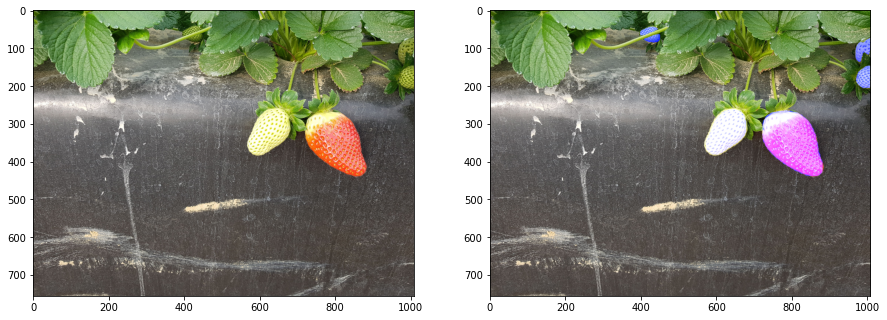

In [ ]:
from random import randrange
#imgs = []
k = iter(data_loader_final_test)
idx = randrange(100)
for a in range(0,idx):
  imgs = next(k)[0]


image = list(img.to(device) for img in imgs)
model.eval()
outputs = model(image)


outputs = [{k: v.to(torch.device("cpu")) for k, v in t.items()} for t in outputs]
plot1(image,outputs)

Custom Train

In [ ]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = StrawberryDataset(f'{root_path}train/',transforms.ToTensor())
dataset_test =StrawberryDataset(f'{root_path}val/',transforms.ToTensor())

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# custom train
metric_logger = utils.MetricLogger(delimiter="  ")
metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
header = 'Epoch: [{}]'
for images, targets in metric_logger.log_every(data_loader, 1, header):
  images = list(image.to(device) for image in images)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
  loss_dict = model(images, targets)
  model.backbone(model.transform(images))
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored

In [ ]:
model.transform(images)

(<torchvision.models.detection.image_list.ImageList at 0x7f4c7a728650>, None)